In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'BAJFINANCE.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,5.239737,5.540927,5.239737,5.412679,3.969872,21923
2002-07-02,5.523439,5.537041,5.421423,5.443769,3.992674,61044
2002-07-03,5.505950,5.545785,5.328151,5.466116,4.009064,34160
2002-07-04,5.501093,5.572018,5.417537,5.528297,4.054671,27892
2002-07-05,5.563274,5.656546,5.474860,5.590478,4.100277,58976
...,...,...,...,...,...,...
2024-04-25,7330.000000,7364.850098,7125.100098,7294.899902,7294.899902,1173354
2024-04-26,7000.000000,7000.000000,6691.500000,6731.200195,6731.200195,5814723
2024-04-29,6789.950195,6839.600098,6713.049805,6826.600098,6826.600098,1681030


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
168/168 [==============================] - 16s 11ms/step - loss: 0.0060
Epoch 2/50
168/168 [==============================] - 2s 12ms/step - loss: 0.0019
Epoch 3/50
168/168 [==============================] - 2s 11ms/step - loss: 0.0014
Epoch 4/50
168/168 [==============================] - 2s 11ms/step - loss: 0.0016
Epoch 5/50
168/168 [==============================] - 2s 11ms/step - loss: 0.0014
Epoch 6/50
168/168 [==============================] - 2s 12ms/step - loss: 0.0012
Epoch 7/50
168/168 [==============================] - 2s 13ms/step - loss: 0.0012
Epoch 8/50
168/168 [==============================] - 2s 10ms/step - loss: 0.0013
Epoch 9/50
168/168 [==============================] - 2s 10ms/step - loss: 0.0012
Epoch 10/50
168/168 [==============================] - 2s 11ms/step - loss: 0.0011
Epoch 11/50
168/168 [==============================] - 2s 10ms/step - loss: 0.0012
Epoch 12/50
168/168 [==============================] - 2s 10ms/step - loss: 0.0011
Epoch 13/50


1/1 [==============================] - 0s 20ms/step


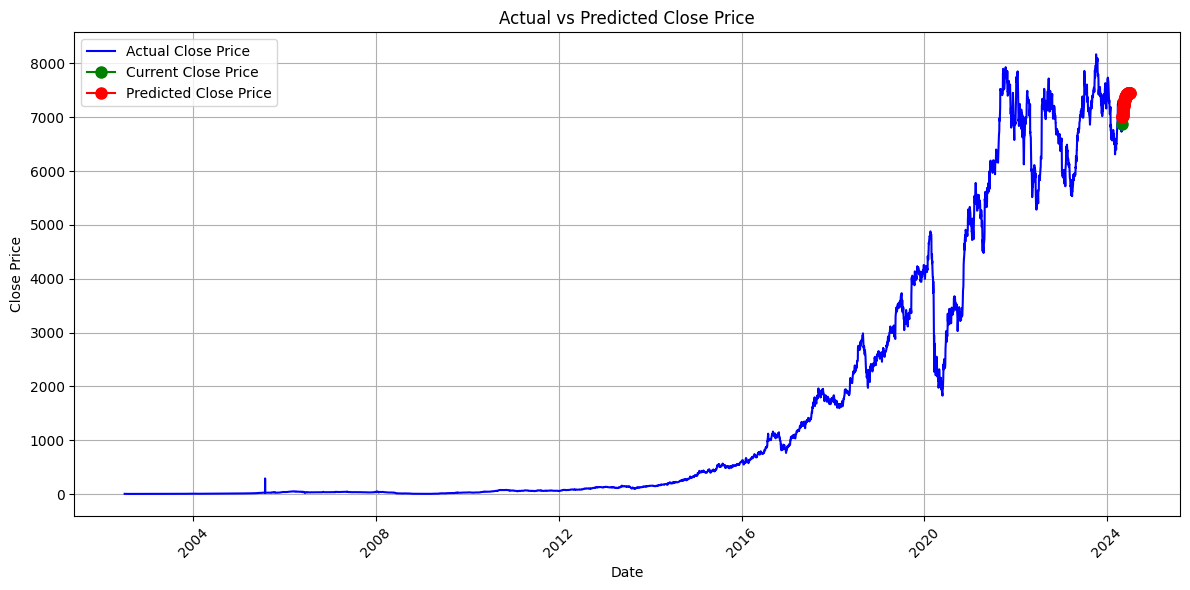

In [8]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted_prices

array([7017.253 , 7006.9976, 7021.0674, 7046.59  , 7075.4614, 7103.922 ,
       7130.434 , 7154.615 , 7176.5786, 7196.6055, 7214.9854, 7231.9604,
       7247.713 , 7262.3735, 7276.0366, 7288.7764, 7300.653 , 7311.7207,
       7322.0312, 7331.632 , 7340.5703, 7348.89  , 7356.633 , 7363.8374,
       7370.539 , 7376.772 , 7382.566 , 7387.95  , 7392.95  , 7397.591 ,
       7401.8955, 7405.8867, 7409.5854, 7413.0103, 7416.181 , 7419.1147,
       7421.8286, 7424.3384, 7426.6587, 7428.8037, 7430.786 , 7432.619 ,
       7434.3135, 7435.879 , 7437.3257, 7438.6636, 7439.9004, 7441.043 ,
       7442.0996, 7443.076 , 7443.978 , 7444.8135, 7445.5835, 7446.2964,
       7446.9556, 7447.564 , 7448.1265, 7448.646 , 7449.126 , 7449.57  ],
      dtype=float32)

In [10]:
model.save('BAJFINANCE.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import joblib
joblib.dump(scaler, 'BAJFINANCE.pkl')

['BAJFINANCE.pkl']